<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Classifier_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os import listdir
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import files
files.upload() 

In [ ]:
import CreatePestImageData as Imagedataset
import SupportingFunctions as support

In [ ]:
support.DownLoadFiles('1aXb25Wp9sG7mL6AQgYY9ElrGcERi95JU',drive)

In [ ]:
support.Unzip('/content/GREENPATROL_DB_V3.0.zip','/content/Pests/Images')

In [ ]:
support.fileCount('/content/Pests/Images')

In [ ]:
dataSet = Imagedataset.createImageDataset()

In [ ]:
class_object = {0 : 'egg_wf' ,
                1 : 'egg_bt', 2 : 'egg_ta', 3 : 'wf', 4 : 'bt', 5 : 'tomato'}

In [ ]:
dataSet.prepare_dataset('/content/Pests/Labels' , class_object ,32, '/content/Pests/Images',  test_size=11241 )

In [ ]:
(trainY , trainX) , (testY , testX ) = (dataSet.trainY , dataSet.trainX ) , (dataSet.testY , dataSet.testX )


In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf

In [ ]:
from keras import backend as K
if K.image_data_format() == 'channels_first':
   input_shape = [3, 32, 32]
else:
   input_shape = [32, 32, 3]

In [ ]:
import tensorflow as tf
from keras import models
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(input_shape=input_shape, include_top=False, pooling='avg',weights='imagenet')
vgg16.summary()

58892288/58889256 [==============================] - 10s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_____________________________________________________________

In [ ]:
from keras.models import Model
layerName = 'block2_pool'
mymodel = Model(inputs= vgg16.input , outputs=vgg16.get_layer(layerName).output)
mymodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
from keras import applications
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

In [ ]:
model= models.Sequential()
model.add(mymodel)
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))
model.layers[0].trainable = True

# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8, 8, 128)         260160    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          18448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [ ]:
from tensorflow.keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [ ]:
filepath="/content/drive/My Drive/Models/VGG16/weights-{epoch:02d}-{accuracy:.3f}.hdf5"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='accuracy',
                               verbose=1, mode='max',save_best_only=True)

callbacks_list = [checkpoint]

In [ ]:
tf.config.experimental_run_functions_eagerly(True)


In [ ]:
model.fit(trainX,trainY,verbose=1,epochs=50,validation_data=(testX,testY),callbacks=[checkpoint])

Train on 44964 samples, validate on 11241 samples
Epoch 1/50
44964/44964 [==============================] - 82s 2ms/step - loss: 0.9439 - accuracy: 0.6295 - val_loss: 0.8672 - val_accuracy: 0.6528

Epoch 00001: accuracy improved from -inf to 0.62946, saving model to /content/drive/My Drive/Models/VGG16/weights-01-0.629.hdf5
Epoch 2/50
44964/44964 [==============================] - 82s 2ms/step - loss: 0.8316 - accuracy: 0.6673 - val_loss: 0.7858 - val_accuracy: 0.6950

Epoch 00002: accuracy improved from 0.62946 to 0.66727, saving model to /content/drive/My Drive/Models/VGG16/weights-02-0.667.hdf5
Epoch 3/50
44964/44964 [==============================] - 83s 2ms/step - loss: 0.7883 - accuracy: 0.6839 - val_loss: 1.1723 - val_accuracy: 0.5490

Epoch 00003: accuracy improved from 0.66727 to 0.68388, saving model to /content/drive/My Drive/Models/VGG16/weights-03-0.684.hdf5
Epoch 4/50
44964/44964 [==============================] - 83s 2ms/step - loss: 0.7763 - accuracy: 0.6892 - val_loss:

In [ ]:
import json
history_dict = model.history.history
json.dump(str(history_dict), open('/content/drive/My Drive/Models/VGG16/History/VGG16_History1.json', 'w'))

In [ ]:
acc = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
loss  =  model.history.history['loss']
val_loss = model.history.history['val_loss']

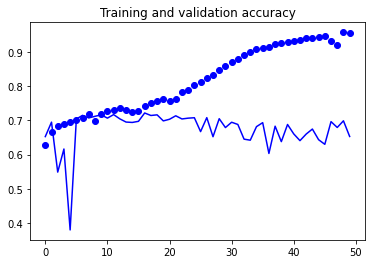

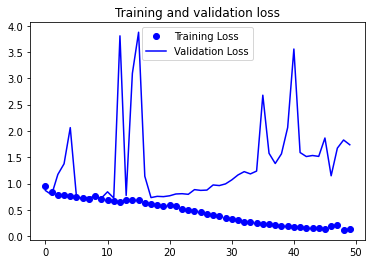

In [ ]:
support.GenerateGraphs(acc, val_accuracy, loss, val_loss)

In [ ]:
support.PrintMetrics(testX_Pred,testY_Pred,model)

Accuracy: 0.653145
Precision: 0.557258
Recall: 0.543670
F1 score: 0.550013
Cohens kappa: 0.495586


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
   
  plt.imshow(img[...,0], cmap=plt.cm.binary)
 
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
   
  plt.xlabel("{} {:2.0f}% ({})".format(class_object[predicted_label],
                                100*np.max(predictions_array),
                                class_object[true_label]),
                                color=color)

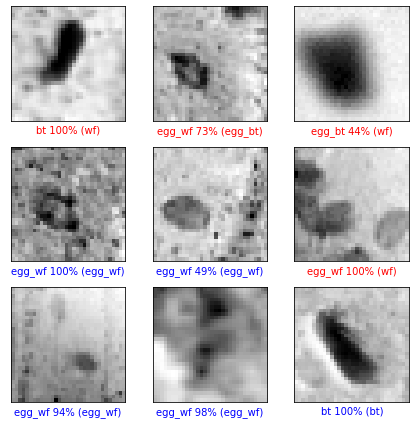

In [ ]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
test_images = testX[:num_images]
predictions = model.predict(testX_Pred)
for i in range(num_images):    
    plt.subplot(num_rows, num_cols, i+1)   
    plot_image(i, predictions, testY_Pred, testX_Pred)    
 
plt.tight_layout()
plt.show()